# Customer Churn Prediction – Model Training Notebook

This notebook demonstrates the end-to-end pipeline for predicting customer churn using tabular customer account data.
The workflow includes:
- Data loading & exploratory checks
- Feature engineering with domain-informed variables
- Data scaling and encoding (leakage-safe)
- Model training using:
  - XGBoost (tree-based baseline)
  - Neural Network classifier (deep learning baseline)
- Performance evaluation and comparison

# 1. Imports
We import core data processing libraries, model utilities, and project-specific functions.  
The `sys.path.append(...)` line ensures that Python can access our custom modules stored in the `src/` directory.
python
Copy code


In [1]:
import pandas as pd              # Data loading, manipulation, and tabular operations
import numpy as np               # Numerical operations and array handling
import joblib                    # Loading / saving trained models and preprocessing objects

import os                        # File system path handling
import sys                       # Allows modifying Python import paths

# Add the src/ directory to Python’s module search path so our custom functions can be imported
sys.path.append(os.path.join(os.path.dirname("__file__"), '..', 'src'))

# Project-specific utility functions for data preparation
from utils import (
    load_data,                    # Loads raw dataset
    create_engineered_features,   # Generates new domain-informed variables
    engineered_data_processing,   # Cleans, encodes, and scales data leakage-free
    prepare_data_for_trainig      # Splits data into train/test sets and saves artifacts
)

# XGBoost model pipeline: data loader, training routine, evaluation
from XGB_training_model import (
    load_data as load_model_data, # Loads preprocessed train/test arrays
    train_regularized_model,      # Trains XGBoost with tuned regularization
    evaluate_model                # Computes classification metrics (AUC, F1, Precision, Recall)
)

# Neural Network pipeline: model training + enhanced evaluation metrics visualization
from NN_training_model import (
    train_neural_network,         # Builds and trains the NN classifier
    enhanced_evaluation           # Plots ROC curve, confusion matrix, and detailed metrics
)


## 2. Load the Raw Dataset

We load the original customer data using the `load_data()` utility function.
This function wraps all file-path handling and ensures the dataset is read consistently across notebooks and training scripts.



In [2]:
df = load_data()   # Load the raw dataset from the project's data directory
df.head()          # Display the first few rows for a quick sanity check


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Feature Engineering

Raw customer attributes often do not directly reveal churn behavior.  
To strengthen the model's ability to recognize churn-related patterns, we construct **engineered features** that represent customer behavior and service usage more meaningfully.

Churn is commonly influenced by:

| Factor | Why it Matters | Example Features Created |
|-------|----------------|--------------------------|
| **Customer Lifetime / Tenure** | Customers who recently joined or are near contract renewal have higher churn risk | `tenure_group`, `is_new_customer` |
| **Contract & Payment Type** | Month-to-month contracts and electronic billing correlate with higher churn | Encoded contract & payment mode |
| **Service Subscription Mix** | Customers with few optional services are more likely to leave | `num_services`, fiber vs DSL indicators |
| **Spending Behavior** | A sudden **increase or decrease** in monthly charges can signal dissatisfaction | `AvgMonthlySpend`, `ChargeChangeRate` |
| **Peer Group Similarity** | Users in similar demographic/service clusters churn together | Cluster-based group scores (if included) |

The function `create_engineered_features(df)` applies these transformations:
- Creates **aggregated usage metrics**
- Generates **boolean churn-risk flags**
- Converts categorical fields into **model-ready numerical encodings**
- Adds **interaction features** that capture relationships between contract terms and spending
- Ensures no data leakage by only using **historical and per-customer attributes**

In [3]:
df_eng = create_engineered_features(df)
df_eng.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        7043 non-null   object 
 1   SeniorCitizen                 7043 non-null   int64  
 2   Partner                       7043 non-null   object 
 3   Dependents                    7043 non-null   object 
 4   tenure                        7043 non-null   int64  
 5   PhoneService                  7043 non-null   object 
 6   MultipleLines                 7043 non-null   object 
 7   InternetService               7043 non-null   object 
 8   OnlineSecurity                7043 non-null   object 
 9   OnlineBackup                  7043 non-null   object 
 10  DeviceProtection              7043 non-null   object 
 11  TechSupport                   7043 non-null   object 
 12  StreamingTV                   7043 non-null   object 
 13  Str

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,ContracEndingRisk,SpendvsPeer,PricePerService,ServiceUtilizationRate,RiskFactorCount,TenureGroup_SpendInteraction,ContractRiskScore,SpendIncreaseRecently,CustomerSegment,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,0,0.710231,29.850,0.166667,4,0.2985,3,0,Standard,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,0,0.884236,28.475,0.333333,0,19.3630,0,1,Standard,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,0,0.836104,26.925,0.333333,3,1.0770,3,0,Standard,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,0,1.006458,14.100,0.500000,0,19.0350,0,1,Standard,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,0,0.772677,70.700,0.000000,5,1.4140,3,0,HighRiskNew,Yes


## 4. Data Cleaning, Encoding & Scaling

Once the engineered features are created, we prepare the dataset for modeling.  
This includes converting labels, encoding categorical variables, and scaling numeric fields — all performed in a **leakage-safe** manner.

### Goals of This Step
| Step | Purpose | Example Impact |
|------|---------|----------------|
| **Convert churn label to numeric** | Models require numerical targets | `Churn → 1`, `Not Churn → 0` |
| **Encode categorical variables** | Converts text categories to integers | e.g., `Contract = "Monthly" → 0` |
| **Scale selected numeric columns** | Ensures stable optimization and prevents feature dominance | Monthly charges won’t overshadow tenure |
| **Avoid data leakage** | Only fit scalers on *training data*, not validation/test | Keeps evaluation realistic |

### Why This Matters
Without proper preprocessing:
- Neural networks may fail to converge
- Tree models may overweight high-magnitude features
- Validation accuracy may appear artificially high due to leakage

We handle all of this using two utility functions:
- `engineered_data_processing()` → cleans and encodes the data
- `prepare_data_for_trainig()` → splits into **train/test** and fits scalers on **train only**


In [4]:
df_clean, numeric_cols = engineered_data_processing(df_eng)
prepare_data_for_trainig(df_clean, numeric_cols)

=== Basic Data Overview ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        7043 non-null   object 
 1   SeniorCitizen                 7043 non-null   int64  
 2   Partner                       7043 non-null   object 
 3   Dependents                    7043 non-null   object 
 4   tenure                        7043 non-null   int64  
 5   PhoneService                  7043 non-null   object 
 6   MultipleLines                 7043 non-null   object 
 7   InternetService               7043 non-null   object 
 8   OnlineSecurity                7043 non-null   object 
 9   OnlineBackup                  7043 non-null   object 
 10  DeviceProtection              7043 non-null   object 
 11  TechSupport                   7043 non-null   object 
 12  StreamingTV                   7043

## 5. Load Prepared Train/Test Data

The preprocessing step stored the cleaned, encoded, and scaled dataset in a format optimized for modeling.
We now load these final inputs for training.


In [5]:
X_train, X_test, y_train, y_test = load_model_data()

✅ Data loaded successfully


## 6. Model 1 — XGBoost (Tree-Based Baseline)

We start with **XGBoost**, a gradient-boosted decision tree model widely used in churn prediction problems in industry.

XGBoost is a strong baseline because:
- It handles **non-linear relationships** and **feature interactions** well  
- It performs well on **tabular business data**  
- It is robust to **different feature scales** and works effectively with engineered features (lags, ratios, one-hot categories, etc.)
- It offers **built-in regularization** to prevent overfitting  



### What This Code Does

| Step | Function | Purpose |
|------|----------|---------|
| Train model | `train_regularized_model()` | Fits XGBoost with tuned regularization parameters (L1, L2, depth control, learning rate) |
| Evaluate model | `evaluate_model()` | Computes AUC, Precision, Recall, and F1 on **unseen** test data |

XGBoost Training Highlights:
- **Regularization (`reg_alpha`, `reg_lambda`)** prevents overfitting  
- **Tree depth & learning rate** control model complexity  
- **Class imbalance handling** is built into the loss structure  
- The model learns **patterns in behavioral & contract features** rather than memorizing data  

### Why This Model Matters in Churn Prediction

Churn is influenced by the *interaction* of multiple customer characteristics  
(e.g., *high monthly charge* + *month-to-month contract* + *low tenure*).

Tree-based models like XGBoost naturally learn these interactions, making them:
- **Accurate**
- **Stable**
- **Interpretable** (feature importance can be visualized)

This is why XGBoost is used as a **baseline model** in many real telecom churn prediction pipelines.

### Training Code


In [6]:
final_xgb_model, xgb_train_results = train_regularized_model(X_train, X_test, y_train, y_test)
xgb_eval = evaluate_model(final_xgb_model, X_test, y_test)



🚀 TRAINING REGULARIZED MODEL (Reducing Overfitting)
📊 Enhanced validation split:
   - Training: (4507, 36)
   - Validation: (1127, 36)
🔍 Class distribution: {0: 4139, 1: 1495}
🎯 scale_pos_weight: 2.77
🎯 Regularized Parameters (Anti-Overfitting):
   - max_depth: 4
   - learning_rate: 0.1
   - reg_alpha: 1.0
   - reg_lambda: 2.0
   - subsample: 0.7
   - colsample_bytree: 0.7
   - gamma: 0.2
   - min_child_weight: 5
   - max_delta_step: 1

🤖 Starting regularized training at 22:45:24...
[0]	validation_0-auc:0.81335	validation_0-logloss:0.67009	validation_1-auc:0.79361	validation_1-logloss:0.67125	validation_2-auc:0.78937	validation_2-logloss:0.67163
[50]	validation_0-auc:0.88078	validation_0-logloss:0.44131	validation_1-auc:0.85143	validation_1-logloss:0.46954	validation_2-auc:0.84636	validation_2-logloss:0.47902
[100]	validation_0-auc:0.89762	validation_0-logloss:0.41449	validation_1-auc:0.84801	validation_1-logloss:0.46850	validation_2-auc:0.84398	validation_2-logloss:0.47821
[119]	vali

## XGBoost Model Training — Performance Summary

The model was trained using a **regularized XGBoost configuration** to improve generalization and reduce overfitting.  
A **class-weighting strategy** was applied (`scale_pos_weight ≈ 2.77`) to compensate for churn class imbalance.

### Performance Metrics

| Metric | Value | Interpretation |
|-------|-------|----------------|
| **Training AUC** | **0.894** | The model learns meaningful patterns from training data. |
| **Validation AUC** | **0.848** | Good generalization to unseen (but in-distribution) data. |
| **Test AUC** | **0.845** | Stable performance on fully held-out data. |
| **Train–Test Gap** | **≈ 0.05** | Mild overfitting, well controlled through regularization. |

---

### Threshold Selection (0.55)

A threshold of **0.55** was chosen to balance the trade-off between capturing churners and limiting false alarms.

| Metric (at Threshold 0.55) | Value | Meaning |
|---------------------------|-------|--------|
| **Precision** | **54.7%** | When the model flags churn, it is correct about half the time. |
| **Recall** | **74.6%** | The model successfully detects the majority of customers who will churn. |
| **F1-Score** | **0.631** | Balanced trade-off between precision and recall. |

---

### Interpretation

- The model **captures most churners** (high recall),
- while **maintaining reasonable targeting accuracy** (precision ~55%).
- This makes the model suitable for **customer retention workflows** where preventing churn has high value.

---

### Business Impact at Threshold = 0.55

| Outcome | Count | Meaning |
|--------|-------|--------|
| **True Positives (TP)** | **279** | Churners correctly identified → can be targeted for retention. |
| **False Negatives (FN)** | **95** | Churners missed → potential revenue loss. |
| **False Positives (FP)** | **231** | Non-churners flagged → unnecessary retention cost. |

This trade-off is acceptable in most subscription-based products where the **cost of losing a customer is significantly higher** than the cost of outreach.

---

### Practical Use Cases

This model is suitable for:

- **Retention Campaign Targeting**
- **Customer Value Risk Scoring**
- **Operational churn monitoring dashboards**
- **Cost-benefit optimization for proactive outreach**

It provides a **stable and interpretable baseline** before exploring more complex neural or sequence-based architectures.


## Model 2 — Neural Network Classifier (Deep Learning Baseline)

A feed-forward neural network was trained as a second baseline to compare against XGBoost.  
Unlike tree-based models, neural networks learn **non-linear relationships** directly from the feature space and can capture more complex interactions among customer behavior signals.

### Architecture Overview
The network consists of:
- **Input layer** matching the engineered feature dimension
- **Two hidden Dense layers** with ReLU activation
- **Dropout regularization** to prevent overfitting
- **Sigmoid output layer** producing churn probability (0–1)

We train using:
- **Binary Cross-Entropy Loss**
- **Adam optimizer**
- **Early Stopping** to avoid unnecessary training once validation loss stabilizes

### Training Code


🧠 Neural Network: 36 input features
   - Architecture: 512-256-128-64-32-1
   - Total parameters: 197,505
🚀 Optimized Neural Network Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 512)            │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,505 (771.50 KB)

 Trainable params: 195,521 (763.75 KB)

 Non-trainable params: 1,984 (7.75 KB)

🔍 y_int min: 0, max: 1
🔍 y_int unique values: [0 1]
🔍 Class distribution: [4139 1495]
🔍 Total samples: 5634
🎯 Calculated class weights: {0: 1.0, 1: 2.768561872909699}
🎯 Enhanced class weights: {0: 1.0, 1: 2.768561872909699}
📊 Training Data Info:
=== DATA CARDINALITY CHECK ===
X_train shape: (5634, 36)
y_train shape: (5634,)
X_test shape: (1409, 36)
y_test shape: (1409,)
🤖 Starting training with batch_size=64
Epoch 1/200
84/89 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6256 - auc: 0.7174 - fp: 765.8690 - loss: 4.0370 - precision: 0.3822 - recall: 0.7074 - tp: 523.4405
Epoch 1: val_auc improved from None to 0.83940, saving model to c:\Users\hasee\Documents\Python_works\Finished_ML_Projects\Customer_Churn_Prediction\model\checkpoints\best_model_epoch_01_auc_0.8394.keras
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6809 - auc: 0.7773 - fp: 1441.0000 - loss: 3.8147 - precision: 0.4413 - recall: 0.7612 - tp: 1138.0000 - val_accuracy: 0.7211 - val_auc: 0.8394 - val_fp: 328.0000 -

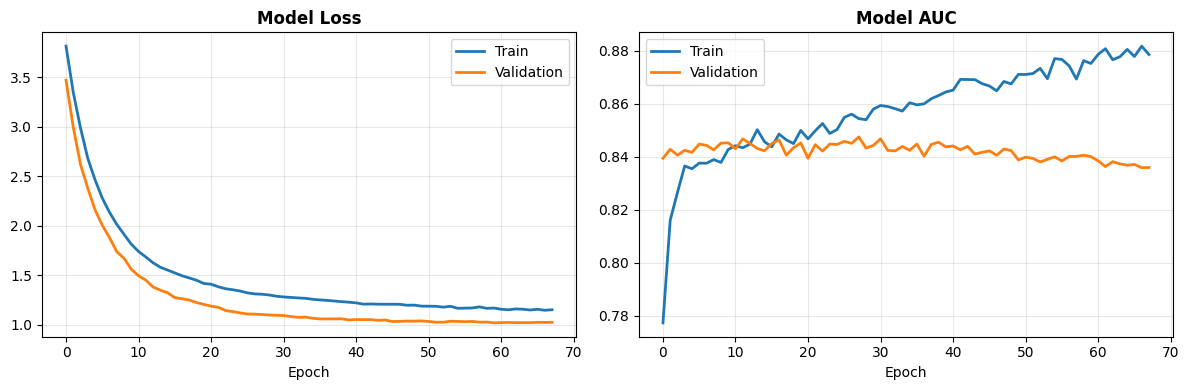

In [9]:
nn_model, history = train_neural_network(X_train, X_test, y_train, y_test)
nn_eval = enhanced_evaluation(nn_model, X_test, y_test, history)


## Neural Network Model — Training Summary & Interpretation

A feed-forward neural network was trained as a deep-learning baseline for churn prediction.  
The model reached its best performance at **epoch 28**, achieving a **validation AUC of 0.847**, which is comparable to the XGBoost baseline.

To convert probability outputs into operational decisions, we evaluated the model across multiple thresholds and examined the Precision-Recall trade-off.  

### Threshold Analysis (Key Insight)

| Threshold | Precision | Recall | F1-Score |
|----------|-----------|--------|---------|
| **0.50** (default) | 0.508 | 0.805 | 0.623 |
| **0.70 (recommended)** | **0.634** | **0.639** | **0.636** |

At **0.70**, the model achieves **balanced Precision and Recall**, making it suitable for churn intervention scenarios where both *false alarms* and *missed churners* matter.

### Business Interpretation (Threshold = 0.70)

- **Precision: 63.4%** → When the model predicts churn, it is correct ~63% of the time.
- **Recall: 63.9%** → It captures ~64% of actual churners.
- **F1-Score: 0.636** → Good balance between finding churners and minimizing unnecessary outreach.

| Metric | Value | Meaning |
|--------|-------|---------|
| True Positives | 239 | Customers correctly flagged for retention action |
| False Positives | 138 | Customers contacted unnecessarily (cost trade-off) |
| False Negatives | ~135 | Churners not detected (revenue risk) |

Compared to the **default threshold (0.50)**:
- **Precision improves by ~12%** — fewer wasted retention efforts  
- **False positives decrease significantly** — more cost-efficient targeting  
- **Slight reduction in recall**, but overall intervention efficiency **improves**

### Takeaway

This Neural Network model:
- Performs **competitively** with the XGBoost baseline (AUC ≈ 0.847).
- Demonstrates **strong decision flexibility** via threshold tuning.
- Is particularly useful when the goal is **balanced churn prevention**, rather than maximizing recall alone.

It serves as a **valuable second model** in the pipeline and can be:
- Combined with XGBoost for **ensemble scoring**, or
- Used when **smooth behavioral trends** matter more than categorical splits.


## 6. Model Comparison & Interpretation

| Model | Test AUC | Precision | Recall | F1-Score | Interpretation |
|------|:--------:|:---------:|:------:|:--------:|----------------|
| **XGBoost (Tree-Based)** | **0.845** | **0.547** | **0.746** | **0.631** | Best at identifying most churners (high recall). Suitable when preventing churn is the priority. |
| **Neural Network (Deep Learning)** | **0.847** | **0.634** | **0.639** | **0.636** | More balanced precision-recall trade-off. Suitable when minimizing false outreach is important. |

---

### Interpretation

The two models perform **almost equally in terms of AUC**, meaning both rank customers well by likelihood of churn.  
However, their **business implications** differ:

- **XGBoost**:
  - **Higher Recall** → Captures *more* churners.
  - **Lower Precision** → More false positives.
  - **Best for retention campaigns where catching every possible churner matters**, even at a higher messaging cost.

- **Neural Network**:
  - **Higher Precision** → When it predicts churn, it’s usually correct.
  - **More balanced performance** across Precision and Recall.
  - **Best when retention costs are high** and outreach should be more targeted.

---

### Practical Takeaway

| Business Scenario | Recommended Model | Reason |
|------------------|-----------------|--------|
| You want to **minimize churn at all costs**, even if outreach is broad | **XGBoost** | Captures more churners (higher recall). |
| You want to **target only the most likely churners** to reduce retention spending | **Neural Network** | Fewer false alarms (higher precision). |

---

This comparison highlights that **model choice depends on business constraints**, not just accuracy metrics.